# Query and Evaluate Performance

This interactive notebook (see Task#3 of the workflow) performs:
1. the import of datasets that are essential for querying and evaluation, such as: user query and relevant judgment;
2. search of each query upon ElasticSearch index, where the enriched metadata are stored;
3. evaluation of performance metrics for search effectiveness;
4. the export of metrics' results to CSV
5. test significant of change using Wilcoxon-signed-rank tests

The query and evaluation can be customized for different:
- indexes in ElasticSearch (i.e. the dataset) defined by "INDEX_SET"; 
- metrics (nDCG, precision and recall) defined by "list_of_metrics"; 
- group of fields included in the search (i.e. title, description) defined by "FIELD_SET".

Search can be performed through three different ways:
1. for a specified index (dataset), loop for all: metrics and group of fields.
2. for a specified index and group of fields, calculate for all metrics.
3. search one user query for a specified index, list of metrics and group of fields.

Prerequisite:
1. ElasticSearch installed. In this experiment, ElasticSearch (version 7.12.0) was deployed through the Docker (version 4.4.2).
2. Metadata is ingested to ElasticSearch's Index database (See Notebook: Task-2-prepare-merge-ingest-data)
3. User queries and relevant judgements were ready to be imported
4. The experiment were conducted with Python 3.9.7

#### More results and plots are documented in Google Sheets: https://docs.google.com/spreadsheets/d/1mmk3y15Qaq_xDIeSNB5_Oackawbeswes0AjoAvul3PE/edit?usp=sharing

![Workflow for the experimental setup in leveraging column semantics for data discovery.](image/workflowv2.png "Workflow")

## 1. Init

In [1]:
# Import Libraries
import os
from functools import partial
import csv
import pandas as pd 
import matplotlib
from collections import defaultdict
import numpy as np
import time


### Setup ElasticSearch

In [2]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch(
    "localhost:9200",
    http_auth=["elastic", "changeme"],
)

In [3]:
from elasticsearch.client import IndicesClient
es_index_client = IndicesClient(es_client)

## 2. Read Queries

### Import User Queries

In [4]:
# Retrieve search queries
def read_queries(root_folder = "./data/"):
    """
        Reads queries in TSV format. The dataset is assumed to be in the folder "./data/" by default
        Returns: A list of 2-tuples: (query_id, query)
    """
    queries = []
    tsv_file = open(os.path.join(root_folder, "data_search_2_e_train_topics.tsv"))
    read_tsv = csv.reader(tsv_file, delimiter="\t")

    for row in read_tsv: queries.append((row[0], row[1]))
    
    tsv_file.close()
    return queries


In [5]:
#### Function check
queries = read_queries()
queries[:5]


[('DS1-E-0001', 'oysters dislike east coast'),
 ('DS1-E-0002',
  'science students increasing humanities students decreasing data'),
 ('DS1-E-0003', 'road length over the years'),
 ('DS1-E-0004', 'domestic self salt rate'),
 ('DS1-E-0005', 'births by month')]

In [6]:
#### Function check
test_query = queries[1]
test_query


('DS1-E-0002',
 'science students increasing humanities students decreasing data')

## 3. Define Methods for ElasticSearch (ES)

In [7]:
# This function returns the index name of the corresponding config
def get_index(index_set):
    """
        Map index_set to the index name represented in ElasticSearch's Index
        Returns: index name 
    """
    assert index_set in {1, 2}
    return {
        1: 'datagov-all-csv-scores', # contains all metadata + enriched information with csv dataset
        2: 'datagov-good-csv-scores' # datagov that only contains good quality of metadata remove Q1 and below in length of desc and attribution
    }[index_set]


In [8]:
# This function returns the index name of the corresponding config
def get_fields(field_set):
    """
        Map field_set to the group of fields to be included in the search
        Returns: group of fields 
    """
    return {
        'basic': ["title", "description", "attribution", "data_organization", "publisher", "tags"] ,
        'basic_semantics': ["title", "description", "attribution", "data_organization", "publisher", "tags", "col_semantics"] ,
        'basic_semantics_s10': ["title", "description", "attribution", "data_organization", "publisher", "tags", "col_semantics_s10"] ,
        'basic_semantics_s20': ["title", "description", "attribution", "data_organization", "publisher", "tags", "col_semantics_s20"] ,
        'basic_semantics_s30': ["title", "description", "attribution", "data_organization", "publisher", "tags", "col_semantics_s30"] ,
        'basic_semantics_s40': ["title", "description", "attribution", "data_organization", "publisher", "tags", "col_semantics_s40"] ,
        'basic_semantics_s50': ["title", "description", "attribution", "data_organization", "publisher", "tags", "col_semantics_s50"] ,
        'basic_semantics_s60': ["title", "description", "attribution", "data_organization", "publisher", "tags", "col_semantics_s60"] ,
        'basic_semantics_s70': ["title", "description", "attribution", "data_organization", "publisher", "tags", "col_semantics_s70"] ,
        'basic_semantics_s80': ["title", "description", "attribution", "data_organization", "publisher", "tags", "col_semantics_s80"] ,
        'basic_semantics_s90': ["title", "description", "attribution", "data_organization", "publisher", "tags", "col_semantics_s90"] ,
        'basic_semantics_s95': ["title", "description", "attribution", "data_organization", "publisher", "tags", "col_semantics_s95"] ,
        'basic_semantics_s98': ["title", "description", "attribution", "data_organization", "publisher", "tags", "col_semantics_s98"] ,
        'basic_semantics_s99': ["title", "description", "attribution", "data_organization", "publisher", "tags", "col_semantics_s99"] ,
        'basic_colnames': ["title", "description", "attribution", "data_organization", "publisher", "tags", "col_names"] ,
        'deprived_semantics': ["title", "col_semantics"] ,
        'deprived_semantics_s10': ["title", "col_semantics_s10"] ,
        'deprived_semantics_s20': ["title", "col_semantics_s20"] ,
        'deprived_semantics_s30': ["title", "col_semantics_s30"] ,
        'deprived_semantics_s40': ["title", "col_semantics_s40"] ,
        'deprived_semantics_s50': ["title", "col_semantics_s50"] ,
        'deprived_semantics_s60': ["title", "col_semantics_s60"] ,
        'deprived_semantics_s70': ["title", "col_semantics_s70"] ,
        'deprived_semantics_s80': ["title", "col_semantics_s80"] ,
        'deprived_semantics_s90': ["title", "col_semantics_s90"] ,
        'deprived_semantics_s95': ["title", "col_semantics_s95"] ,
        'deprived_semantics_s98': ["title", "col_semantics_s98"] ,
        'deprived_semantics_s99': ["title", "col_semantics_s99"] ,
        'title_only': ["title"] ,
        'semantic_only': ["col_semantics"],
        'deprived_colnames': ["title", "col_names"] ,
        'exclude_desc': ["title", "attribution", "data_organization", "publisher", "tags"] ,
        'exclude_attr': ["title", "description", "data_organization", "publisher", "tags"] ,
        'exclude_tags': ["title", "description", "attribution", "data_organization", "publisher"] 
    }[field_set]


In [9]:
# Search Function
def es_search(query, index_set, field_set):
    """
        Perform search over all documents with the given query.
        Input: 
            query - a (unprocessed) query (here in ES, assume that ES handle the pre-processing)
            index_set - the index to use
            field_set - the group of fields to search on
        Output: a list of (document_id, score), sorted in descending relevance to the given query
    """
    index = get_index(index_set)
    fields = get_fields(field_set)
#     print('index: {}, fields: {}, query: {}'.format(index, fields, query))
    search_query = {
        "query": {
            "multi_match" : {
                "query" : query,
                "fields" : fields 
            }
        }
    }
    result = es_client.search(index=index, body=search_query, size=50) # Note: search result set at max 50
    output = [(doc['_id'],doc['_score']) for doc in result['hits']['hits']]
    time.sleep(0.01) # Sleep timer to avoid inaccurate results
    
    return output

In [10]:
#### Function check
test_result = es_search(test_query[1],1, 'basic')
test_result[:1]

[('ac9c8c22-8e04-457c-a2a0-c07a7a2a50a2', 17.309746)]

## 4. Read Relevance Judgement

In [11]:
# Prepare relevance document

def map_relevance_level(level):
    """
        Map relevance level retrieved from NTCIR dataset to relevance score
        Output: relevance score
    """
    assert level in {'L0', 'L1', 'L2'}
    return {
        'L0': float(0),
        'L1': float(1),
        'L2': float(2)
    }[level]

def read_qrels(root_folder = "./data/"):
    """
        Reads the qrels.text file for relevance judgment 
        Output: A dictionary of dictionary: query_id -> [list of tuples (relevant documents -> true relevance)]
    """
    relevant_docs = defaultdict(defaultdict)
    txt_file = open(os.path.join(root_folder, "data_search_2_e_train_qrels.txt"))
    read_txt = csv.reader(txt_file, delimiter=" ")
    
    for row in read_txt: 
        score = map_relevance_level(row[2])
        if (score>0):
            relevant_docs[row[0]] = relevant_docs[row[0]]+[(row[1],score)] if row[0] in relevant_docs else [(row[1],score)]
    
    txt_file.close()
    return relevant_docs


In [12]:
#### Function check
qrels = read_qrels()
qrels[test_query[0]]

[('05f019e6-48a1-4e87-9c5e-61e920db2fb2', 1.0),
 ('06aede0a-6b2f-44f2-b8e6-20a0fba9460b', 1.0),
 ('0c3900b4-3b8e-4421-bf49-b21dc7f7a2a1', 1.0),
 ('32e8c902-4510-4a65-b7b9-5587281f2b24', 1.0),
 ('4390538d-a871-4187-99d8-348736cac6d8', 1.0),
 ('536ac4d3-4e3f-4fb4-95db-54eef3dedd3c', 1.0),
 ('683a1afb-4ed9-4d95-a496-9a85109f912f', 1.0),
 ('6a299299-d7fe-425d-805a-34819278a251', 1.0),
 ('6f61cf1a-ec44-49a3-8e00-c6123d7389ee', 1.0),
 ('74df254d-193e-4de7-aaf4-0d5f5b306e84', 1.0),
 ('86ed1fda-1602-40dc-aec0-e935eedbb6d0', 1.0),
 ('97acffe8-ecbe-4819-b802-24886c8a9f49', 1.0),
 ('aa3bf9f4-1832-4d27-b2e9-7b928546c339', 1.0),
 ('c219f4cf-30f4-4ca1-b3a6-7a55f5a95c52', 1.0),
 ('cfd9fb08-ac9e-4cf6-a894-6e5fefce1708', 1.0),
 ('f36a7c58-a3bf-4d4c-9478-922f53622a80', 1.0),
 ('ff5ec6cc-a621-49f6-911f-9f06b3a65916', 2.0)]

## 5. Define Methods for Performance Evaluation

In [13]:
def dcg(rel, k):
    """
        Calculate metric DCG of the given relevance ("rel") at @k
        Output: An DCG score
    """
    total_dcg=0
    for i in range(0,k):
        num = np.exp(rel[i]) - 1
        denom = np.log2(i + 2)
        total_dcg += num/denom
    return total_dcg

def ndcg(true, pred, k):
    """
        Normalise DCG with the ideal DCG at @k
        Output: A normalised NDCG
    """
    if (dcg(true,k) < 0.01):
        print ('pred_rel: {}'.format(pred))
        print ('true_rel: {}'.format(true))
        print ('ndcg: {}'.format(dcg(pred,k)/dcg(true,k)))
        
    return dcg(pred,k)/dcg(true,k)

In [14]:
# CHECK
print(dcg([2,1,1,1,1], k=5))
print(dcg([0,0,0,0,1], k=5))
print(ndcg([2,1,1,1,1], [0,0,0,0,1], k=5))

9.737057996396432
0.6647221489594827
0.06826724758191728


In [15]:
def ndcg_k(results, relevant_docs, k):
    """
        Compute Normalised Discounted Cumulative Gain @k for a single query
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most relevant document 
            in the first position
            relevant_docs: A dictionary of relevant documents and its true relevance. 
            k: the cut-off
        Output: nDCG@K
    """
    if len(results) == 0:
        return 0
    
    if k > len(results):
        k = len(results)
    
    pred_relevance = [] # list of ground-truth relevance of a query:
    doc_ids = list(zip(*relevant_docs))[0] # get list of relevant documents IDs [0], 
    doc_rels = list(zip(*relevant_docs))[1] # and list of relevant score [1]
    
    for i in range(0,k):
        if results[i][0] in doc_ids: #if document is relevant
            i = doc_ids.index(results[i][0]) # get index of the relevance list
            pred_relevance += [doc_rels[i]] 
        else:
            pred_relevance += [float(0)]
    
    scores = list(list(zip(*results))[1])[:k] # predicted scores (relevance) for the answers
    true_relevance = np.pad(-np.sort(-np.asarray(doc_rels)),(0, max(0, len(scores) - len(doc_rels))), 'constant')[:k] # sort ideal relevance
    result = ndcg(true_relevance, pred_relevance, k=k)
    
    return result


In [16]:
# precision = true_pos / all positive prediction
def precision_k(results, relevant_docs, k):
    """
        Calculate precision at @k with formula: true positive / all positive prediction
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most relevant document 
            in the first position
            relevant_docs: A dictionary of relevant documents and its true relevance. 
            k: the cut-off
        Output: p@k
    """
    if len(results) == 0:
        return 0.0
    if k > len(results):
        k = len(results)
        
    n_relevant_k=0
    rel_docs_list = list(list(zip(*relevant_docs))[0])

    for i in range(0,k):
        if results[i][0] in rel_docs_list:
            n_relevant_k += 1
        
    return n_relevant_k/k


In [17]:
# recall = true_pos / all relevant doc exist
def recall_k(results, relevant_docs, k):
    """
        Calculate recall at @k with formula: true positive / all relevant document @k
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most relevant document 
            in the first position
            relevant_docs: A dictionary of relevant documents and its true relevance. 
            k: the cut-off
        Output: r@k
    """
    if len(results) == 0:
        return 0.0
    if k > len(results):
        k = len(results)
        
    n_relevant_k=0
    rel_docs_list = list(list(zip(*relevant_docs))[0])
    
    for i in range(0,k):
        if results[i][0] in rel_docs_list:
            n_relevant_k += 1
    
    return n_relevant_k / len(rel_docs_list)


In [18]:
#### Function check
print(ndcg_k(test_result, qrels[test_query[0]], k=10))
print(precision_k(test_result, qrels[test_query[0]], k=10))
print(recall_k(test_result, qrels[test_query[0]], k=10))

0.450703582577222
0.5
0.29411764705882354


### Define list of metrics

In [19]:
#### metrics@k functions

ndcg_at_5 = partial(ndcg_k, k=5)
ndcg_at_10 = partial(ndcg_k, k=10)
ndcg_at_50 = partial(ndcg_k, k=50)

precision_at_5 = partial(precision_k, k=5)
precision_at_10 = partial(precision_k, k=10)
precision_at_50 = partial(precision_k, k=50)

recall_at_5 = partial(recall_k, k=5)
recall_at_10 = partial(recall_k, k=10)
recall_at_50 = partial(recall_k, k=50)

list_of_metrics = [
    ("nDCG@5", ndcg_at_5),
    ("nDCG@10", ndcg_at_10),
    ("nDCG@50", ndcg_at_50),
    ("p@5", precision_at_5),
    ("p@10", precision_at_10),
    ("p@50", precision_at_50),
    ("r@5", recall_at_5),
    ("r@10", recall_at_10),
    ("r@50", recall_at_50),
    ]


In [20]:
#### Define list of search function. In this experiment, only ElasticSearch was implemented
list_of_search_fns = [
    ("ElasticSearch", es_search)
]

def evaluate_search_fn(search_fn, metric_fns, index_set, field_set):
    """
        Evaluate performance based on the specified search function, list of metrics, index and fields.
        Input: 
            search_fn: the search function, i.e. ElasticSearch
            metric_fns: list of metrics to evaluate with
            index_set: index name in ElasticSearch
            field_set: group of fields to be included
        Output: a list of dictionaries containing averaged metrics results, with query-level details such as: 
                metric scores, list of relevant documents and ES search scores
    """
    # build a dict query_id -> query 
    queries_by_id = dict((q[0], q[1]) for q in queries)
    
    metrics = {}
    for metric, metric_fn in metric_fns:
        metrics[metric] = np.zeros(len(qrels), dtype=np.float32)

    detailed_result = [] # to store output at query-doc level
    for i, (query_id, relevant_docs) in enumerate(qrels.items()):
        query = queries_by_id[query_id]
        results = search_fn(query, index_set, field_set)
        
        for metric, metric_fn in metric_fns:
            metrics[metric][i] = metric_fn(results, relevant_docs)
    
        detailed_result += [{'index_set': index_set, 'field_set': field_set
                             , 'query_id': query_id, 'query': query
                             , 'nDCG@5': metrics['nDCG@5'][i].mean()
                             , 'nDCG@10': metrics['nDCG@10'][i].mean()
                             , 'nDCG@50': metrics['nDCG@50'][i].mean()
                             , 'p@5': metrics['p@5'][i].mean()
                             , 'p@10': metrics['p@10'][i].mean()
                             , 'p@50': metrics['p@50'][i].mean()
                             , 'r@5': metrics['r@5'][i].mean()
                             , 'r@10': metrics['r@10'][i].mean()
                             , 'r@50': metrics['r@50'][i].mean()
                             , 'result': [i[0] for i in results], 'search_score': [i[1] for i in results] 
                             , 'not_found':[j for j in relevant_docs if j[0] not in [i[0] for i in results]]
                             , 'rel_docs': relevant_docs}]

    final_dict = {}
    for metric, metric_vals in metrics.items():
        final_dict[metric] = metric_vals.mean() #averaged for all queries
    
    final_dict['result'] = detailed_result
    return final_dict

## 6. Evaluate and Export

In [33]:
# specify folder for output files
DIR_OUTPUT = '/Users/mmargaret/Documents/[UVA] Thesis/data-discovery/output/'

In [34]:
# specify group of fields to be search upon
FIELD_SET = ['basic','basic_semantics', 
        'basic_semantics_s10', 'basic_semantics_s20', 'basic_semantics_s30', 'basic_semantics_s40',
        'basic_semantics_s50', 'basic_semantics_s60', 'basic_semantics_s70', 'basic_semantics_s80',
        'basic_semantics_s90', 'basic_semantics_s95', 'basic_semantics_s98', 'basic_semantics_s99',
        'basic_colnames',
        'deprived_semantics',
        'deprived_semantics_s10', 'deprived_semantics_s20', 'deprived_semantics_s30', 'deprived_semantics_s40',
        'deprived_semantics_s50', 'deprived_semantics_s60', 'deprived_semantics_s70','deprived_semantics_s80',
        'deprived_semantics_s90', 'deprived_semantics_s95', 'deprived_semantics_s98', 'deprived_semantics_s99',
        'title_only','semantic_only',
        'deprived_colnames',
        'exclude_desc','exclude_attr', 'exclude_tags']


### Option 1 - loop and compute for the specified index, for:
1. all field sets (i.e. semantic_only) in the list; 
2. all search types (only ElasticSearch in this study) in the list;
3. all metrics in the list.

In [35]:
# Specify index set: 1: 'datagov-all-csv-scores', 2: 'datagov-good-csv-scores'.
INDEX_SET = 1

In [36]:
result_merge = pd.DataFrame()

for curr_field in FIELD_SET:

    result_dict1 = defaultdict(float)
    
    for fn in list_of_search_fns:
        result_dict1[curr_field] = evaluate_search_fn(fn[1], list_of_metrics, INDEX_SET, curr_field).values()

    result_df1_all = pd.DataFrame.from_dict(result_dict1, 
                                       columns = ['nDCG@5','nDCG@10','nDCG@50'
                                                  ,'p@5','p@10','p@50'
                                                  ,'r@5','r@10','r@50'
                                                  ,'details'],
                                      orient='index')
    
    # Export query-level result for analysis if necessary (CSV)
    detailed_df = pd.DataFrame.from_dict(result_df1_all['details'][0])
    detailed_df.to_csv(DIR_OUTPUT + 'results_'+ str(INDEX_SET) +'_'+ curr_field +'.csv', index=False)
    
    # Append result for the current group of fields
    result_merge = result_merge.append(result_df1_all)
    
    # Status check
    print(result_df1_all[['nDCG@10','nDCG@50']].to_dict(orient='index'))

result_merge = result_merge [['nDCG@5','nDCG@10','nDCG@50', 'p@5','p@10','p@50','r@5','r@10','r@50']]
result_merge.to_csv(DIR_OUTPUT + 'results_'+ str(INDEX_SET) +'.csv', index=True)


{'basic': {'nDCG@10': 0.1737252026796341, 'nDCG@50': 0.20833750069141388}}
{'basic_semantics': {'nDCG@10': 0.17363108694553375, 'nDCG@50': 0.20823633670806885}}
{'basic_semantics_s10': {'nDCG@10': 0.17363108694553375, 'nDCG@50': 0.20823633670806885}}
{'basic_semantics_s20': {'nDCG@10': 0.17363108694553375, 'nDCG@50': 0.2082354724407196}}
{'basic_semantics_s30': {'nDCG@10': 0.17363108694553375, 'nDCG@50': 0.20823152363300323}}
{'basic_semantics_s40': {'nDCG@10': 0.17363108694553375, 'nDCG@50': 0.20822687447071075}}
{'basic_semantics_s50': {'nDCG@10': 0.1737252026796341, 'nDCG@50': 0.2083210051059723}}
{'basic_semantics_s60': {'nDCG@10': 0.17363108694553375, 'nDCG@50': 0.20822511613368988}}
{'basic_semantics_s70': {'nDCG@10': 0.1737252026796341, 'nDCG@50': 0.20832233130931854}}
{'basic_semantics_s80': {'nDCG@10': 0.1737252026796341, 'nDCG@50': 0.20831872522830963}}
{'basic_semantics_s90': {'nDCG@10': 0.1737252026796341, 'nDCG@50': 0.20831817388534546}}
{'basic_semantics_s95': {'nDCG@10':

### Option 2: interactive mode - loop for an index and a field set, compute: 
1. all metrics; and 
2. using all search functions.

In [28]:
INDEX_SET = 1 # Specify an index set

curr_field = FIELD_SET[0] # Specify the group of fields
curr_field

'basic'

In [29]:
result_dict1 = defaultdict(float)

for fn in list_of_search_fns:
    result_dict1[curr_field] = evaluate_search_fn(fn[1], list_of_metrics, INDEX_SET, curr_field).values()

result_df1_all = pd.DataFrame.from_dict(result_dict1, 
                                   columns = ['nDCG@5','nDCG@10','nDCG@50'
                                              ,'p@5','p@10','p@50'
                                              ,'r@5','r@10','r@50'
                                              ,'details'],
                                  orient='index')


In [30]:
# Display results
result_df1 = result_df1_all [['nDCG@10','nDCG@50'
                                ,'p@10','p@50'
                                ,'r@10','r@50']]
result_df1

,nDCG@10,nDCG@50,p@10,p@50,r@10,r@50
basic,0.173725,0.208338,0.131361,0.049007,0.181112,0.298208


In [31]:
# Export as query-level results CSV for analysis
detailed_df = pd.DataFrame.from_dict(result_df1_all['details'][0])
detailed_df.to_csv(DIR_OUTPUT + 'results_'+ str(INDEX_SET) +'_'+ curr_field +'.csv', index=False)

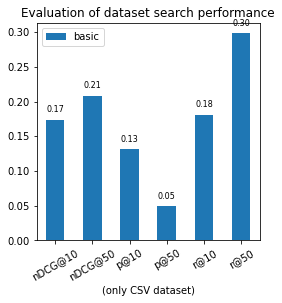

In [32]:
import matplotlib
ax = result_df1.transpose().plot.bar(rot=30, title='Evaluation of dataset search performance',
                          xlabel='(only CSV dataset)', 
                                     figsize=(4,4), width=0.5)
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)


### Option 3: interactive mode - test a query

In [23]:
QUERY_ID = 'DS1-E-0021' # Specify a query
INDEX_SET = 1 # Specify an index set

curr_field = FIELD_SET[0] # Specify the group of fields
curr_field

'basic'

In [24]:
# Retrieve query
queries_df = pd.DataFrame(queries, columns = ['id', 'query'])
query_df = queries_df[queries_df.id == QUERY_ID]
test_query = query_df.to_records(index = False)[0]
test_query


('DS1-E-0021', 'average utility expenses')

In [25]:
# Search and retrieve results
test_result = es_search(test_query[1], INDEX_SET, curr_field)
test_result


[('8c355330-d32b-4137-b9ce-70a0e4f135bc', 9.519936),
 ('8566f34a-541a-4042-96ff-43d2f8c37994', 9.092283),
 ('0088362c-cc1a-405e-aa07-75de830651e0', 8.761575),
 ('6b75cdf8-102f-4db5-b30b-4ba027834d8f', 8.241793),
 ('2e59092b-c9aa-48ab-80f5-fab766c122a7', 8.130519),
 ('911468a8-f6c3-40bf-8e41-0301b6519639', 8.031216),
 ('ae5a34f0-438c-4eb8-b261-dfd088947f5b', 7.93165),
 ('7bfa94b1-18c2-4081-a319-5c1333cc0b16', 7.469602),
 ('4cac0154-f374-43ef-87d7-9b4142b1305e', 7.3379564),
 ('2a208933-c2c5-4f23-9c63-4771358d199d', 7.121032),
 ('0bdde0b3-fb4b-4875-8701-d0bbdde54be7', 6.982303),
 ('6a2ff66e-3bff-488c-af71-2035e3b4c94d', 6.912698),
 ('2cec8ff4-b062-4366-ba4c-1d4a4458f57f', 6.6488976),
 ('3f1e03d4-c18f-4fe2-af9a-237d5eb8cef2', 6.6488976),
 ('00423fd4-9269-424c-952a-b9e60d627213', 6.4067106),
 ('7efb8fc8-1557-4393-b122-d0ab982cc071', 6.4067106),
 ('7e42a54f-fdd2-4293-816b-08b504bca070', 6.1266036),
 ('81b721d8-b580-433c-a9d2-8f6a33f5a03e', 5.9955797),
 ('fad5c0ba-9792-448f-98e5-8d2ebebaaa44'

In [26]:
# Relevance judgement
qrels[test_query[0]]

[('0bdde0b3-fb4b-4875-8701-d0bbdde54be7', 1.0),
 ('0ea80f0f-dd80-4ec3-991b-5ff55c471621', 2.0),
 ('2d845e81-cc46-4c09-bd69-8b40eb309953', 1.0),
 ('6b4b42fe-49c2-406b-bd7d-9fbc21317f6a', 1.0),
 ('842c067e-32cb-4a84-b50e-847e60b677e9', 1.0),
 ('911468a8-f6c3-40bf-8e41-0301b6519639', 1.0),
 ('afdceaab-c870-4ad9-8e40-3667b14449f3', 1.0)]

In [27]:
# Evaluate
print(ndcg_k(test_result, qrels[test_query[0]], k=50))
print(precision_k(test_result, qrels[test_query[0]], k=50))
print(recall_k(test_result, qrels[test_query[0]], k=50))

0.099924796593535
0.04
0.2857142857142857


#### More results and plots are documented in Google Sheets: https://docs.google.com/spreadsheets/d/1mmk3y15Qaq_xDIeSNB5_Oackawbeswes0AjoAvul3PE/edit?usp=sharing

## 7. Significance Tests
The Wilcoxon-tests were performed through interactive mode during our study

In [43]:
from scipy.stats import wilcoxon

### Define constants based on the filenames of the exported results

In [44]:
#BENCHMARK
FILE_BENCHMARK = 'output/results_1_basic.csv'
FILE_SEMANTIC_ENRICHED_METADATA = 'output/results_1_basic_semantics.csv'
FILE_SEMANTIC_ENRICHED_METADATA_99 = 'output/results_1_basic_semantics_s99.csv'
FILE_COLNAME_ENRICHED_METADATA = 'output/results_1_basic_colnames.csv'

In [45]:
#POOR
FILE_TITLE_ONLY = 'output/results_1_title_only.csv'
FILE_SEMANTIC_ENRICHED_TITLE = 'output/results_1_deprived_semantics.csv'
FILE_SEMANTIC_ENRICHED_TITLE_98 = 'output/results_1_deprived_semantics_s98.csv'

### Specify the comparable test results to measure

In [46]:
base = pd.read_csv(FILE_TITLE_ONLY)
new = pd.read_csv(FILE_SEMANTIC_ENRICHED_TITLE_98)

base.sort_values(by='query_id', inplace=True)
new.sort_values(by='query_id', inplace=True)

print(len(base))
print(len(new))

169
169


### Specify one metric to compare

In [47]:
METRIC_NAME = 'nDCG@10'# can be in ['nDCG@50', 'p@10', 'p@50', 'r@10', 'r@50']

In [48]:
base_values = base[METRIC_NAME]
new_values = new[METRIC_NAME]
base_values[:5]

0    0.000000
1    0.512030
2    0.000000
3    0.047976
4    0.201922
Name: nDCG@10, dtype: float64

### Calculate difference

In [49]:
diff_values = new_values - base_values
diff_values[diff_values!=0.0]

48    -0.067943
131   -0.094265
Name: nDCG@10, dtype: float64

### Perform test

#### 2-tailed test

In [50]:
w, p = wilcoxon(diff_values)
w, p

/Users/mmargaret/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


(0.0, 0.17971249487899976)

#### 1-tailed test

In [51]:
w, p = wilcoxon(diff_values, alternative='greater')
w, p

(0.0, 0.9101437525605001)

In [52]:
w, p = wilcoxon(diff_values, alternative='less')
w, p

(0.0, 0.08985624743949988)